In [107]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeCV, LassoCV, Lasso
from sklearn.cross_validation import cross_val_score

%matplotlib inline

# ---------------- 500ms, Perf on Attacked Binary ------------------ 

In [108]:
adata = pd.read_csv('Data/Attacked/500ms.txt', delim_whitespace=True)
adata = adata.drop(adata.columns[3], axis=1)
adata = adata.drop(adata.columns[3], axis=1)
adata = adata.drop(adata.columns[3], axis=1)
adata = adata.drop(adata.columns[3], axis=1)
adata = adata.drop(adata.columns[3], axis=1)
adata.columns = ['Time', 'Value', 'Type']
adata.head()

,Time,Value,Type
0,0.505896,5698587,cache-references
1,0.505896,1373690,cache-misses
2,0.505896,314784633,cycles
3,0.505896,309279292,instructions
4,0.505896,20824700,branches


In [109]:
instructions = adata[adata.Type.isin(['instructions'])]
cache_misses = adata[adata.Type.isin(['cache-misses'])]
cache_ref = adata[adata.Type.isin(['cache-references'])]
page_faults = adata[adata.Type.isin(['faults'])]
cycles = adata[adata.Type.isin(['cycles'])]
migrations = adata[adata.Type.isin(['migrations'])]
branches = adata[adata.Type.isin(['branches'])]
context = adata[adata.Type.isin(['context-switches'])]

cycles

,Time,Value,Type
2,0.505896,314784633,cycles
10,1.007363,833474840,cycles
18,1.508233,1314696599,cycles
26,2.009226,1367382516,cycles
34,2.509779,1370115742,cycles
42,3.010592,1388872468,cycles
50,3.511960,1395402092,cycles
58,4.013316,1374253287,cycles
66,4.513588,1357398808,cycles
74,5.014327,1360968219,cycles


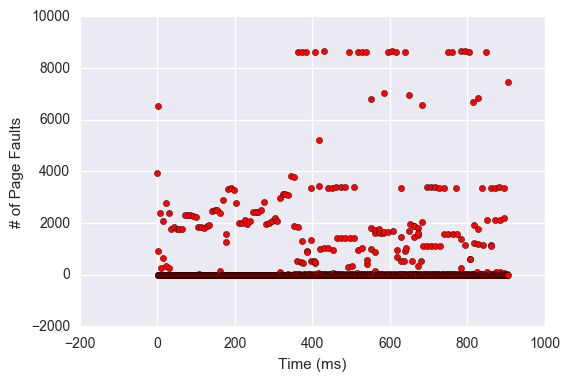

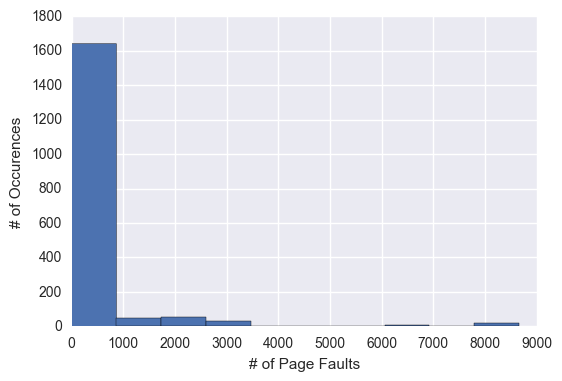

In [110]:
plt.scatter(page_faults.Time, page_faults.Value, c='r')
plt.xlabel('Time (ms)')
plt.ylabel('# of Page Faults')
plt.show()

plt.hist(page_faults.Value)
plt.xlabel('# of Page Faults')
plt.ylabel('# of Occurences')
plt.show()

In [111]:
miss_rate = (cache_misses.Value.mean()/cache_ref.Value.mean())
print "Cache miss rate: " 
print miss_rate

Cache miss rate: 
0.732756636677


# -------------------------Benchmark Data, ZeusMP, 75ms----------------------------

In [112]:
data = pd.read_csv('Data/Benchmark/500ms_ZeusMP.txt', delim_whitespace=True)
data = data.drop(data.columns[3], axis=1)
data = data.drop(data.columns[3], axis=1)
data = data.drop(data.columns[3], axis=1)
data = data.drop(data.columns[3], axis=1)
data = data.drop(data.columns[3], axis=1)
data.columns = ['Time', 'Value', 'Type']

In [113]:
ben_instructions = data[data.Type.isin(['instructions'])]
ben_cache_misses = data[data.Type.isin(['cache-misses'])]
ben_cache_ref = data[data.Type.isin(['cache-references'])]
ben_page_faults = data[data.Type.isin(['faults'])]
ben_cycles = data[data.Type.isin(['cycles'])]
ben_migrations = data[data.Type.isin(['migrations'])]
ben_branches = data[data.Type.isin(['branches'])]
ben_context = data[data.Type.isin(['context-switches'])]

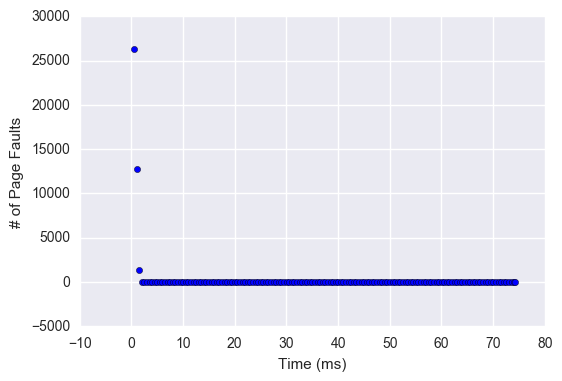

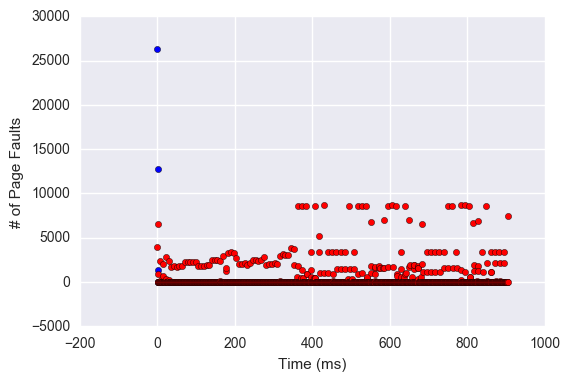

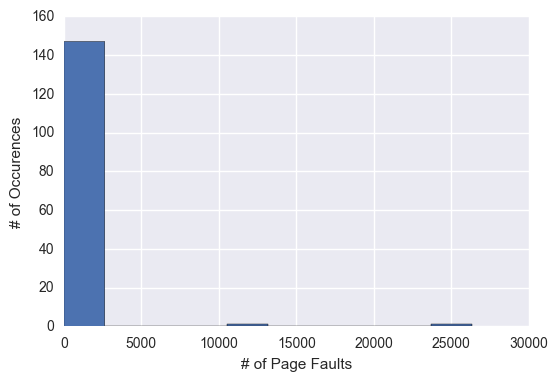

In [114]:
plt.scatter(ben_page_faults.Time, ben_page_faults.Value)
plt.xlabel('Time (ms)')
plt.ylabel('# of Page Faults')
plt.show()

plt.scatter(ben_page_faults.Time, ben_page_faults.Value)
plt.scatter(page_faults.Time, page_faults.Value, c='r')
plt.xlabel('Time (ms)')
plt.ylabel('# of Page Faults')
plt.show()

plt.hist(ben_page_faults.Value)
plt.xlabel('# of Page Faults')
plt.ylabel('# of Occurences')
plt.show()

In [115]:
miss_rate = (ben_cache_misses.Value.mean()/ben_cache_ref.Value.mean())
miss_std = ben_cache_misses.Value.std()
print "Cache miss rate: " 
print miss_rate

Cache miss rate: 
0.633169688669


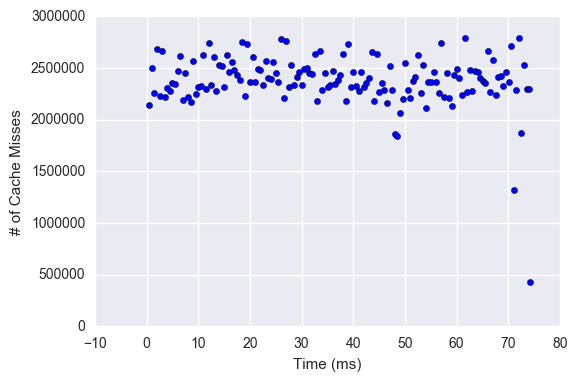

Mean: 
2380925.24161
STD: 
255928.051595


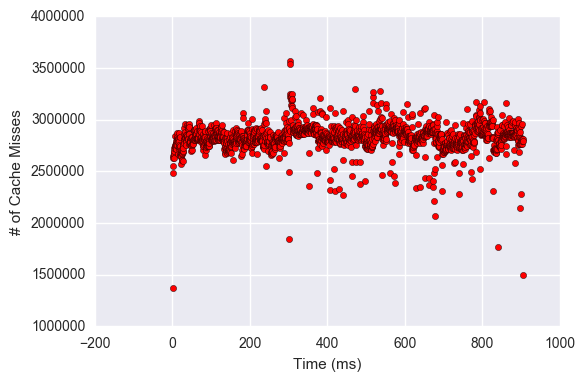

Mean: 
2831641.11517
STD: 
130623.328907


In [116]:
plt.scatter(ben_cache_misses.Time, ben_cache_misses.Value)
plt.xlabel('Time (ms)')
plt.ylabel('# of Cache Misses')
plt.show()

print "Mean: "
print ben_cache_misses.Value.mean()
print "STD: "
print ben_cache_misses.Value.std()

plt.scatter(cache_misses.Time, cache_misses.Value, c='r')
plt.xlabel('Time (ms)')
plt.ylabel('# of Cache Misses')
plt.show()

print "Mean: "
print cache_misses.Value.mean()
print "STD: "
print cache_misses.Value.std()

# ----------- Creating a Model ----------------

In [117]:
# First, we need to preprocess the data
instructions.index = range(len(instructions))
cache_misses.index = range(len(cache_misses))
cache_ref.index = range(len(cache_ref))
page_faults.index = range(len(page_faults))
cycles.index = range(len(cycles))
migrations.index = range(len(migrations))
branches.index = range(len(branches))
context.index = range(len(context))

ben_instructions.index = range(len(ben_instructions))
ben_cache_misses.index = range(len(ben_cache_misses))
ben_cache_ref.index = range(len(ben_cache_ref))
ben_page_faults.index = range(len(ben_page_faults))
ben_cycles.index = range(len(ben_cycles))
ben_migrations.index = range(len(ben_migrations))
ben_branches.index = range(len(ben_branches))
ben_context.index = range(len(ben_context))

ones = pd.DataFrame(np.ones(len(instructions)))
zeros = pd.DataFrame(np.zeros(len(ben_instructions)))

attack_data = pd.concat([instructions.Value, cache_misses.Value, cache_ref.Value, page_faults.Value, 
                        cycles.Value, migrations.Value, branches.Value, context.Value, ones], axis=1)

bench_data = pd.concat([ben_instructions.Value, ben_cache_misses.Value, ben_cache_ref.Value, ben_page_faults.Value, 
                        ben_cycles.Value, ben_migrations.Value, ben_branches.Value, ben_context.Value, zeros], axis=1)

total_data = pd.concat([attack_data, bench_data], axis=0)
total_data.columns = ['Instructions', 'Cache_misses', 'Cache_references', 'Page_Faults', 'Cycles', 'Migrations', 
                      'Branches', 'Context', 'Type']
total_data = total_data.drop('Migrations', axis=1)
total_data

,Instructions,Cache_misses,Cache_references,Page_Faults,Cycles,Branches,Context,Type
0,309279292,1373690,5698587,3943,314784633,20824700,951,1.0
1,447935063,2485850,7433802,6541,833474840,81743102,379,1.0
2,507024178,2551686,3473215,906,1314696599,86518993,23,1.0
3,295105078,2653091,3477981,0,1367382516,26963126,4,1.0
4,294581351,2625417,3438486,0,1370115742,26910162,7,1.0
5,299852096,2685859,3506404,0,1388872468,27410453,3,1.0
6,300531677,2666144,3477385,0,1395402092,27474840,3,1.0
7,296631059,2628828,3442046,0,1374253287,27136061,4,1.0
8,291209991,2695914,3603033,0,1357398808,26598869,10,1.0
9,290681827,2721976,3642362,0,1360968219,26519314,6,1.0


In [118]:
msk = np.random.rand(len(total_data)) < 0.8
train = total_data[msk]
test = total_data[~msk]

X = total_data.ix[:, :7]
y = total_data.ix[:, 7]

X_train = train.ix[:,:7]
y_train = train.ix[:,7]

X_test = test.ix[:,:7]
y_test = test.ix[:,7]

In [123]:
model_ridge = RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y_train)
pred = model_ridge.predict(X_test)

pred_norm = (pred - pred.mean()) / (pred.max() - pred.min())
pred_norm = pred_norm - pred_norm.min()
pred_norm

array([ 0.06171978,  0.06158146,  0.06036946,  0.05619933,  0.06242869,
        0.06234446,  0.06141146,  0.06347093,  0.06063467,  0.06316927,
        0.0659653 ,  0.08849816,  0.05908969,  0.05764117,  0.06226442,
        0.05744571,  0.05784704,  0.05655696,  0.06673865,  0.0597213 ,
        0.06213255,  0.06204087,  0.06173638,  0.05883346,  0.05916332,
        0.05847343,  0.06215848,  0.05692987,  0.05886433,  0.06439924,
        0.05968297,  0.05967426,  0.0630457 ,  0.05890626,  0.06177572,
        0.06072221,  0.06274368,  0.05865847,  0.05799616,  0.06434965,
        0.05981658,  0.06493047,  0.06028316,  0.06194548,  0.05838017,
        0.06000498,  0.06316455,  0.06196725,  0.06948484,  0.06096357,
        0.05961465,  0.05563597,  0.05979565,  0.05873263,  0.06135212,
        0.06132757,  0.06424681,  0.06081649,  0.06536473,  0.06093181,
        0.06118857,  0.06211391,  0.11410018,  0.059832  ,  0.06110984,
        0.060657  ,  0.064547  ,  0.05588767,  0.0582121 ,  0.05

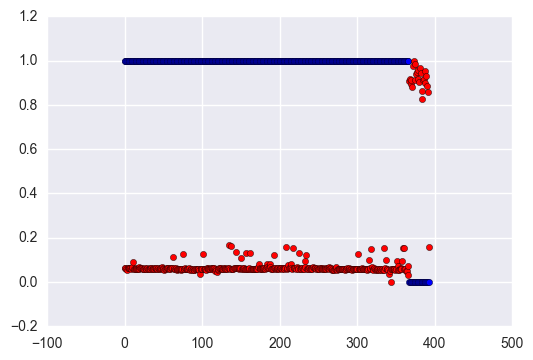

In [124]:
plt.scatter(range(0,len(X_test)), y_test)
plt.scatter(range(0,len(X_test)), pred_norm, c='r')
plt.show()

In [125]:
ridge_score = -cross_val_score(model_ridge, X_train, y_train, scoring="mean_squared_error")
print("Ridge Best RMSE: {}".format(np.sqrt(ridge_score).mean()))

Ridge Best RMSE: 192192.887859


/Users/JamesZhang/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/JamesZhang/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/JamesZhang/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


In [126]:
model_lasso = LassoCV(alphas= [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y_train)
pred = model_lasso.predict(X_test)

pred_norm = (pred - pred.mean()) / (pred.max() - pred.min())
pred_norm = pred_norm - pred_norm.min()
pred_norm

array([ 0.95245967,  0.9530639 ,  0.95491085,  0.94571464,  0.96557629,
        0.96183055,  0.96206268,  0.97330383,  0.95241057,  0.95669999,
        0.96591549,  0.95444446,  0.96111651,  0.95330499,  0.9731001 ,
        0.95342256,  0.95071655,  0.94761738,  0.92991451,  0.95870971,
        0.96634306,  0.97009468,  0.9691802 ,  0.95733136,  0.95536591,
        0.94998309,  0.96176677,  0.95172877,  0.95536571,  0.97625362,
        0.95702887,  0.95910377,  0.96973941,  0.95626111,  0.96565727,
        0.96149414,  0.96906664,  0.95349422,  0.95091569,  0.97504038,
        0.957866  ,  0.97660523,  0.96130604,  0.96602669,  0.95203383,
        0.96008926,  0.97346002,  0.96799334,  0.94735021,  0.96308176,
        0.96082169,  0.94727965,  0.95747467,  0.95293798,  0.95644874,
        0.95982211,  0.96772656,  0.95166862,  0.968428  ,  0.95363104,
        0.95821615,  0.95863931,  0.93964549,  0.95367094,  0.96553783,
        0.96266432,  0.97583181,  0.94588946,  0.954783  ,  0.95

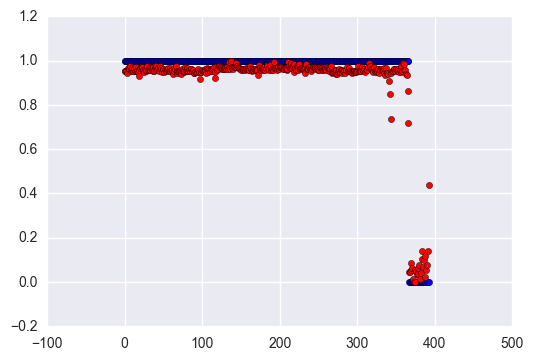

In [127]:
plt.scatter(range(0,len(X_test)), y_test)
plt.scatter(range(0,len(X_test)), pred_norm, c='r')
plt.show()

In [129]:
lasso_score = -cross_val_score(model_lasso, X, y, scoring="mean_squared_error")
print("Lasso Best RMSE: {}".format(np.sqrt(lasso_score).mean()))

Lasso Best RMSE: 0.173797558662


/Users/JamesZhang/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/JamesZhang/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/JamesZhang/anaconda/lib/python2.7/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
